# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import BayesianOptimization
from keras_tuner import HyperParameters as hp

def get_model_results(yt, yp):
    print('MSE: ', round(mean_squared_error(yt, yp), 2))
    print('RMSE: ', round(mean_squared_error(yt, yp) ** 0.5, 2))
    print('MAE: ', round(mean_absolute_error(yt, yp),2))
    print('R2: ', round(r2_score(yt, yp), 2))

import warnings
warnings.filterwarnings('ignore')

# Problem Statement 

- We need to estimate accurately the time it takes to deliver the order to the customer.
- We have data of nearly 2 Lakh orders with ~15 features that might affect the delivery time.
- We will be building regression models for prediction of delivery time.

# Insights

- We have 2 Lakh orders with an average delivery time of 37 minutes.
- RF gave a MSE of 202.66 and R2 score of 0.19
- NN gave a MSE of 192.77 and R2 score of 0.23
- NN is better able to predict the delivery time as compared to RF on the test data.

# Loading Data

In [7]:
df = pd.read_csv('dataset.csv')

# Basic EDA

In [8]:
df.shape

(197428, 14)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [10]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [11]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
count,196441.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000
mean,2.978706,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065
std,1.524867,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000
25%,2.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000
50%,3.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000
75%,4.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000
max,6.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000


In [12]:
df.describe(include='O')

,created_at,actual_delivery_time,store_id,store_primary_category
count,197428,197421,197428,192668
unique,180985,178110,6743,74
top,2015-02-11 19:50:43,2015-02-11 20:40:45,d43ab110ab2489d6b9b2caa394bf920f,american
freq,6,5,937,19399


In [13]:
# Null Rates
df.isna().sum().sort_values(ascending=False)

total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
store_primary_category       4760
order_protocol                995
market_id                     987
actual_delivery_time            7
created_at                      0
store_id                        0
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
dtype: int64

# Data preprocessing and feature engineering

In [14]:
# not required
df = df.drop(columns=['store_id'])

# dropping null values from actual_delivery_time as this is required to create target variable
df.dropna(subset=['actual_delivery_time'], inplace=True)

In [15]:
# Convert to datetime
for c in ['created_at', 'actual_delivery_time']:
    df[c] = pd.to_datetime(df[c], format='%Y-%m-%d %H:%M:%S')

In [16]:
# get the delivery time in minutes
df['delivery_time_in_mins'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()/60
df['delivery_time_in_mins'] = df['delivery_time_in_mins'].round()

# get the day of the week from created_at
df['day_of_week'] = df['created_at'].dt.day_of_week

# get the hour from created_at
df['hour'] = df['created_at'].dt.hour

# not required anymore
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

df.reset_index(drop=True, inplace=True)


In [17]:
df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time_in_mins,day_of_week,hour
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,4,22
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,1,21
2,3.0,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,3,20
3,3.0,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,1,21
4,3.0,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,6,2


### Handling Missing Values

In [18]:
CAT_COLS = ['store_primary_category']
NUM_COLS = ['market_id', 'order_protocol', 'total_items', 'subtotal','num_distinct_items', 'min_item_price',
             'max_item_price','total_onshift_partners', 'total_busy_partners','total_outstanding_orders','day_of_week','hour']

In [19]:
df[CAT_COLS] = df[CAT_COLS].astype('str')
df[NUM_COLS] = df[NUM_COLS].astype('float')

In [20]:
CAT_IMPUTER = SimpleImputer(missing_values='nan', strategy='most_frequent', add_indicator=True)
NUM_IMPUTER = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', add_indicator=True, )

df_cat = pd.DataFrame(CAT_IMPUTER.fit_transform(df[CAT_COLS]), columns=CAT_IMPUTER.get_feature_names_out(CAT_COLS))
df_num = pd.DataFrame(NUM_IMPUTER.fit_transform(df[NUM_COLS]), columns=NUM_IMPUTER.get_feature_names_out(NUM_COLS))

df.drop(columns=CAT_COLS + NUM_COLS, inplace=True)
df = pd.concat([df, df_cat, df_num], axis=1)

In [21]:
df.head()

,delivery_time_in_mins,store_primary_category,missingindicator_store_primary_category,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,day_of_week,hour,missingindicator_market_id,missingindicator_order_protocol,missingindicator_total_onshift_partners,missingindicator_total_busy_partners,missingindicator_total_outstanding_orders
0,63.0,american,False,1.0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,4.0,22.0,0.0,0.0,0.0,0.0,0.0
1,67.0,mexican,False,2.0,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0
2,30.0,american,True,3.0,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0
3,51.0,american,True,3.0,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0
4,40.0,american,True,3.0,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Null Rates
df.isna().sum().sort_values(ascending=False)

delivery_time_in_mins                        0
store_primary_category                       0
missingindicator_total_busy_partners         0
missingindicator_total_onshift_partners      0
missingindicator_order_protocol              0
missingindicator_market_id                   0
hour                                         0
day_of_week                                  0
total_outstanding_orders                     0
total_busy_partners                          0
total_onshift_partners                       0
max_item_price                               0
min_item_price                               0
num_distinct_items                           0
subtotal                                     0
total_items                                  0
order_protocol                               0
market_id                                    0
missingindicator_store_primary_category      0
missingindicator_total_outstanding_orders    0
dtype: int64

### DataType Conversion

In [23]:
df['missingindicator_store_primary_category'] = df['missingindicator_store_primary_category'].astype('int')

### Frequency Encoding

In [24]:
df['store_primary_category'].nunique()

74

In [25]:
FREQ_DICT = (round(df['store_primary_category'].value_counts(1) * 100, 2)).to_dict()
df['store_primary_category'] = df['store_primary_category'].apply(lambda x: FREQ_DICT.get(x,0))

In [27]:
df.head()

,delivery_time_in_mins,store_primary_category,missingindicator_store_primary_category,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,day_of_week,hour,missingindicator_market_id,missingindicator_order_protocol,missingindicator_total_onshift_partners,missingindicator_total_busy_partners,missingindicator_total_outstanding_orders
0,63.0,12.24,0,1.0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,4.0,22.0,0.0,0.0,0.0,0.0,0.0
1,67.0,8.66,0,2.0,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0
2,30.0,12.24,1,3.0,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0
3,51.0,12.24,1,3.0,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0
4,40.0,12.24,1,3.0,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0


# Data visualization and Outlier Removal

#### Before outlier removal

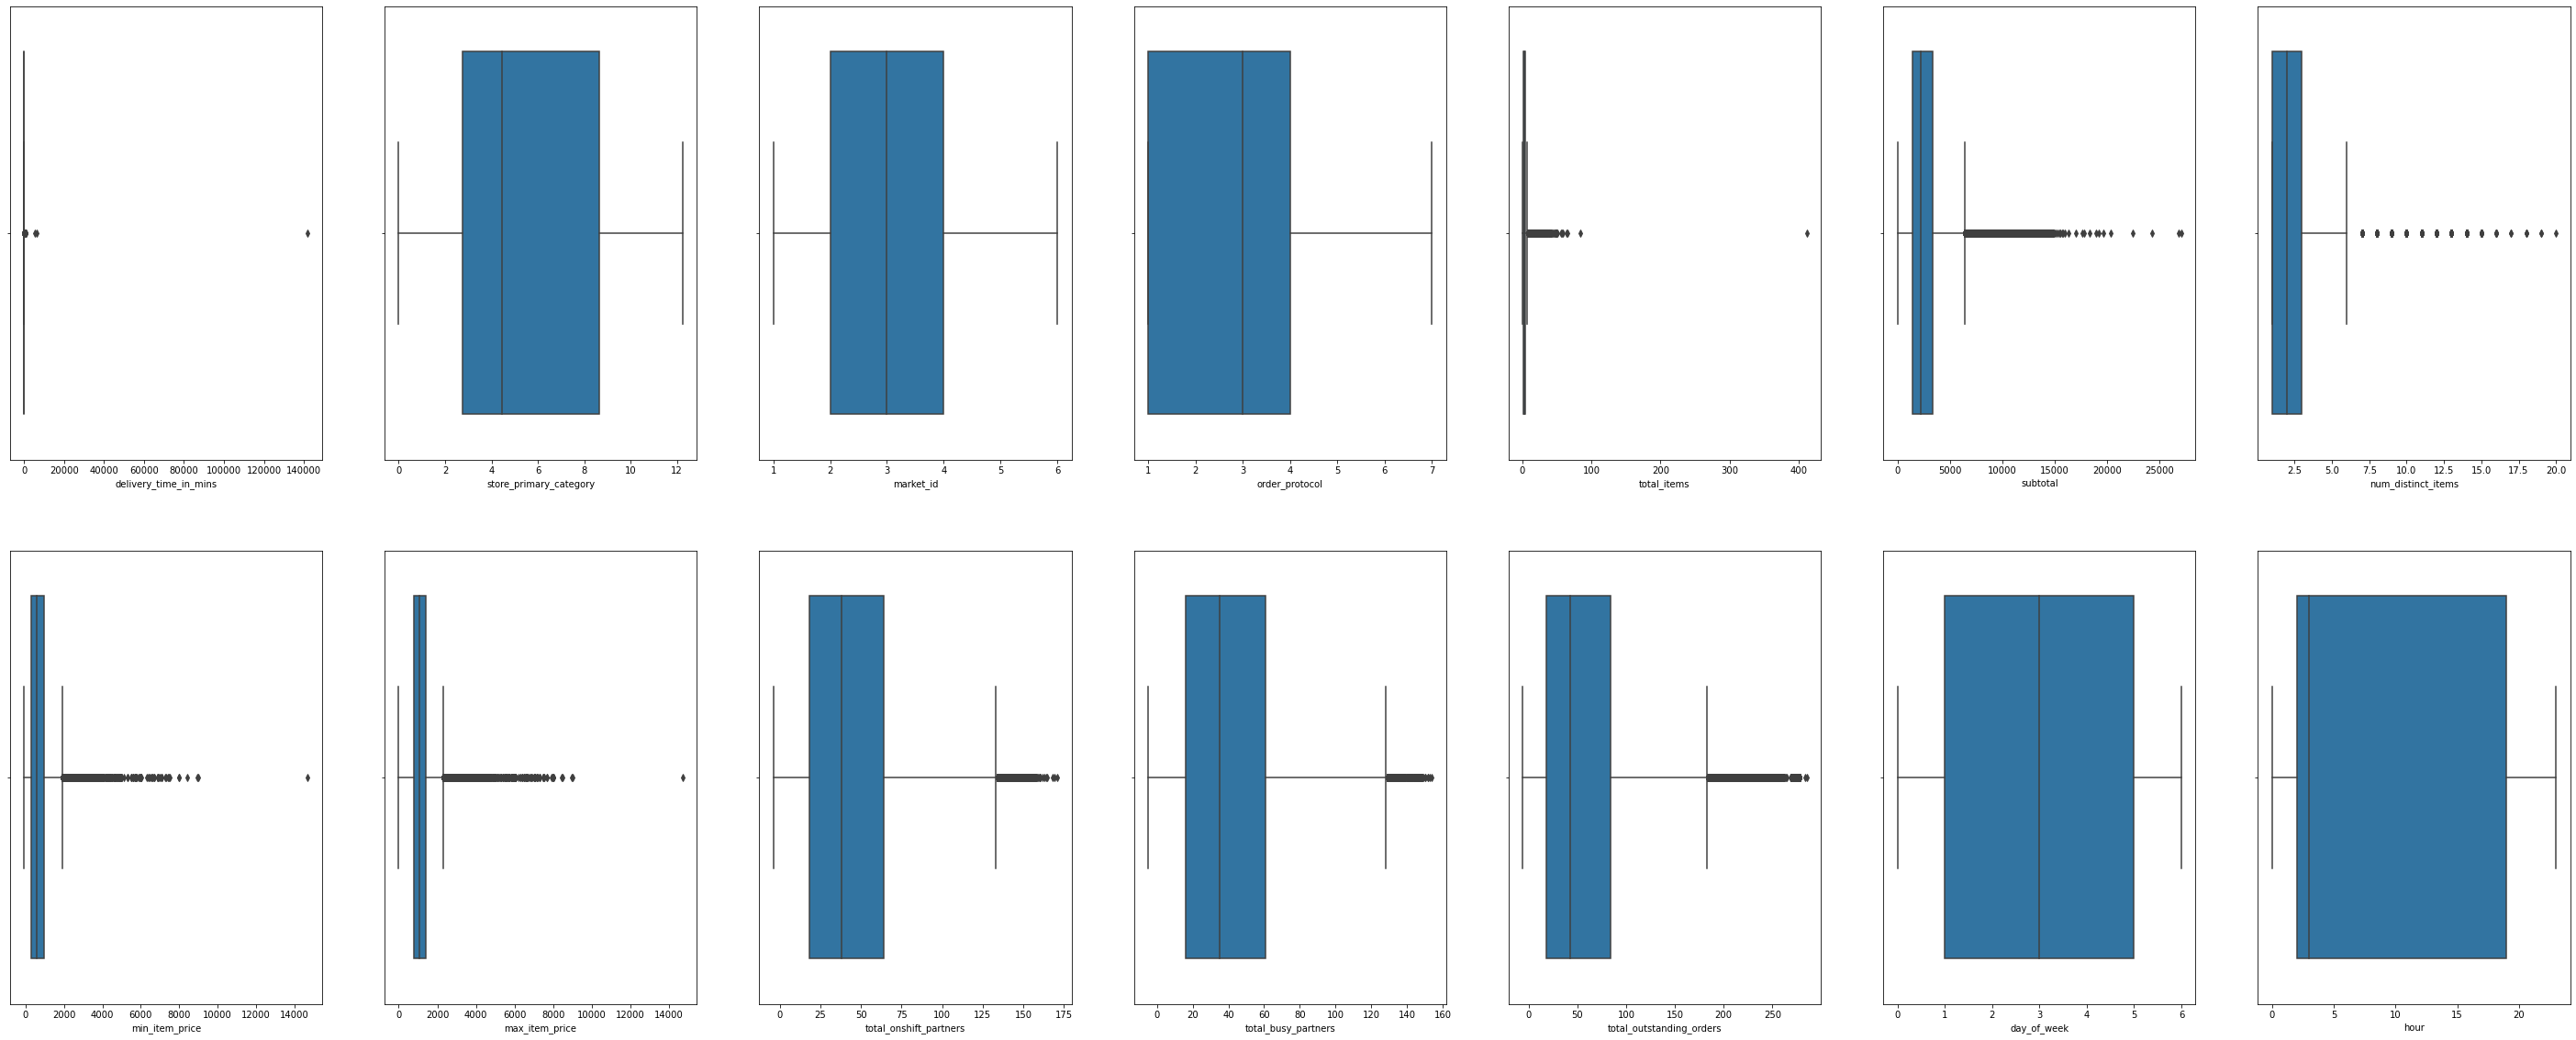

In [3]:
# Visualize only relevant columns
viz_df = df.loc[:, [i for i in df.columns if 'missingindicator' not in i]].copy(deep=True)
fig,ax = plt.subplots(2,7,figsize=(50, 20))
for i,col in enumerate(viz_df.columns):
    sns.boxplot(x=col, data=viz_df, ax=ax[i//7][i%7])

In [6]:
POSSIBLE_OUTLIER_COLS = ['delivery_time_in_mins','total_items','subtotal','num_distinct_items','min_item_price', 'max_item_price']
IF = IsolationForest(n_estimators=1000, random_state=42, n_jobs=-1)
OUTLIER_FLAG = IF.fit_predict(df[POSSIBLE_OUTLIER_COLS])
df = df[OUTLIER_FLAG == 1]
df.reset_index(drop=True, inplace=True)
df.shape

In [4]:
df.shape

(173805, 20)

#### After outlier removal

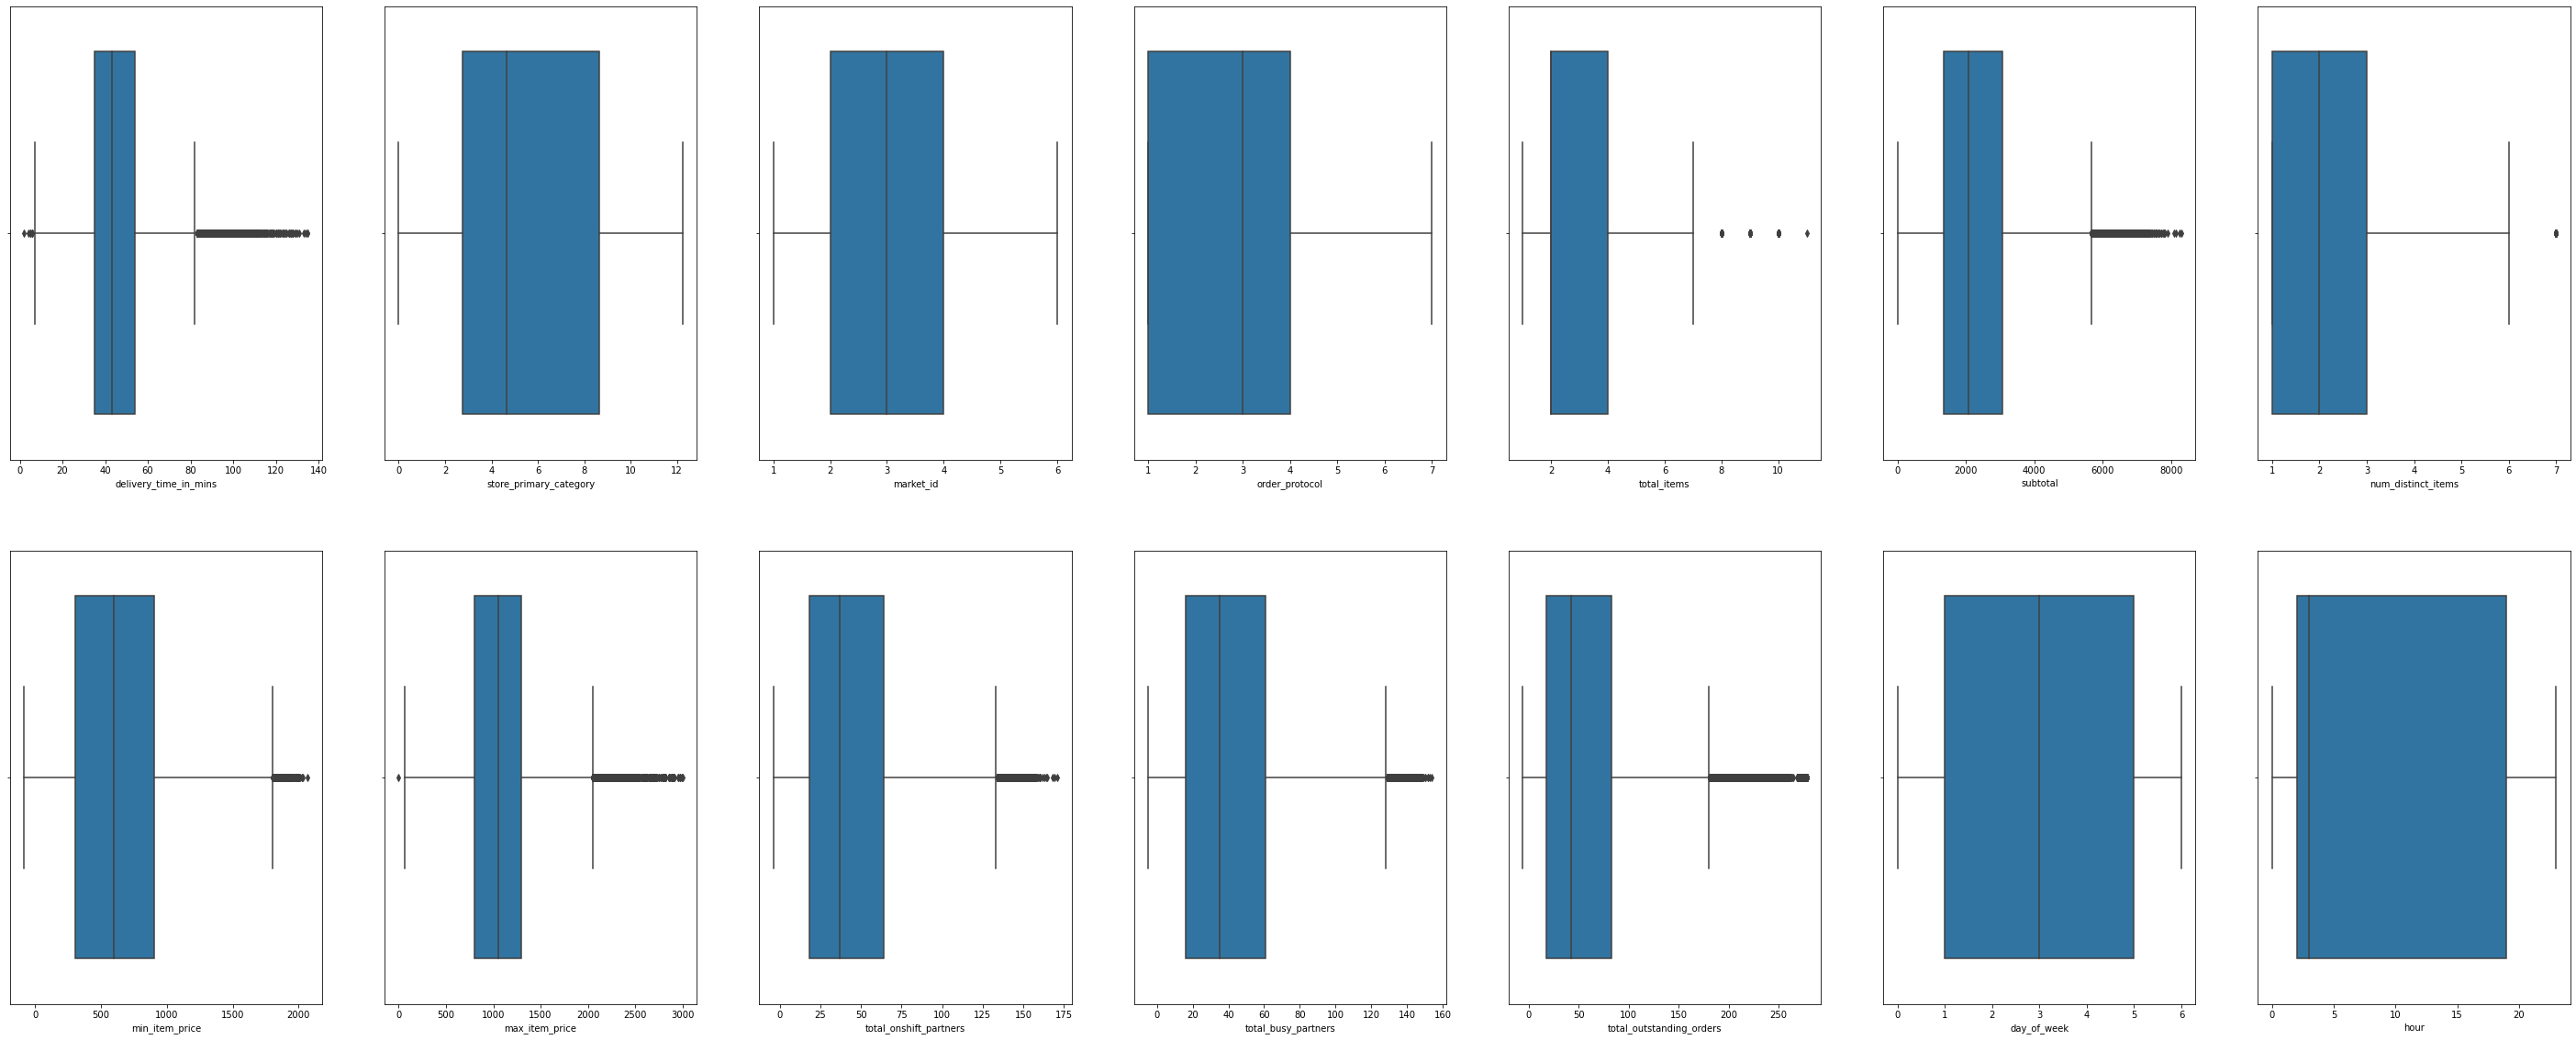

In [5]:
# Visualize only relevant columns
viz_df = df.loc[:, [i for i in df.columns if 'missingindicator' not in i]]
fig,ax = plt.subplots(2,7,figsize=(50, 20))
for i,col in enumerate(viz_df.columns):
    sns.boxplot(x=col, data=viz_df, ax=ax[i//7][i%7])

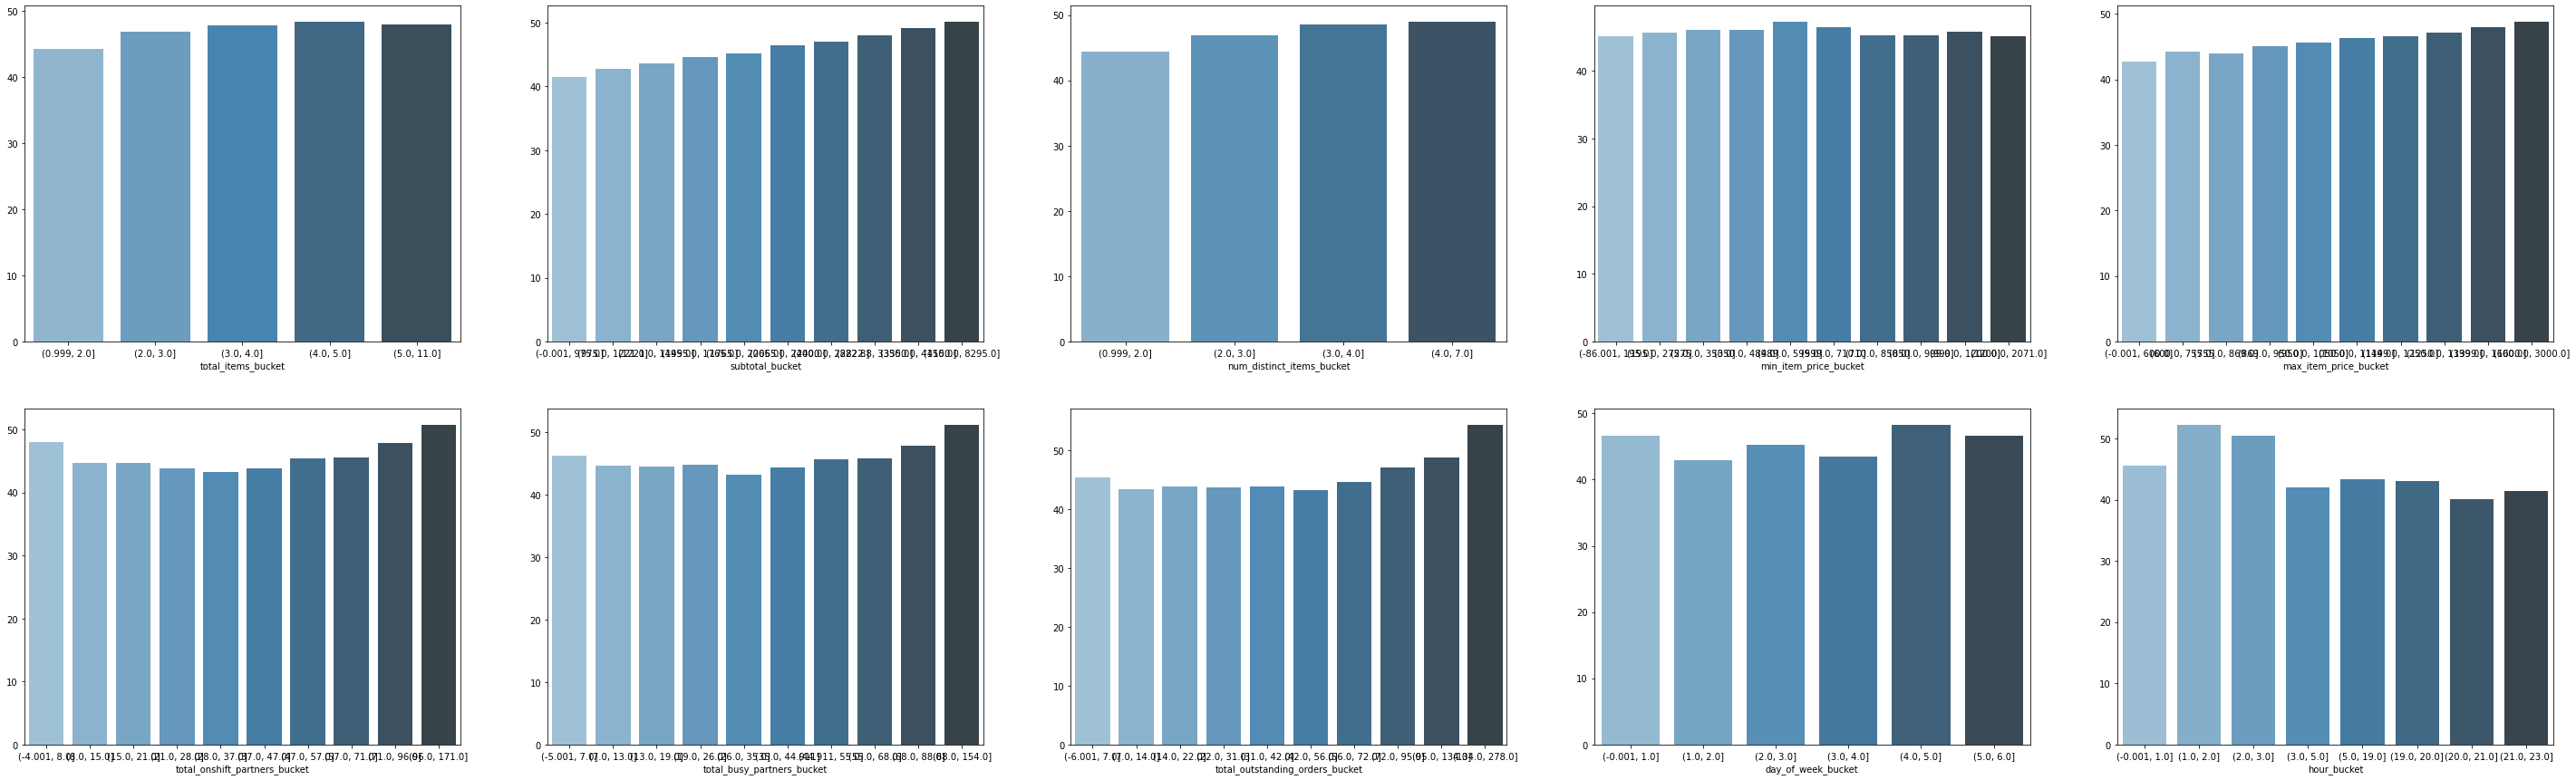

In [6]:
fig,ax = plt.subplots(2,5,figsize=(50, 15))
for e, col in enumerate(['total_items', 'subtotal','num_distinct_items', 'min_item_price','max_item_price','total_onshift_partners', 'total_busy_partners','total_outstanding_orders','day_of_week','hour']):
    viz_df[col + '_bucket'] = pd.qcut(viz_df[col], q=10, duplicates='drop')
    tmp = viz_df.groupby(col + '_bucket')['delivery_time_in_mins'].mean()   
    sns.barplot(x=tmp.index, y=tmp.values, ax=ax[e//5][e%5], palette='Blues_d')

# Model training

In [7]:
X, y = df.drop(columns=['delivery_time_in_mins']), df['delivery_time_in_mins']
X.shape, y.shape, y.mean()

((173805, 19), (173805,), 45.82422830183251)

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape , y_train.mean(), y_test.mean()

((139044, 19),
 (34761, 19),
 (139044,),
 (34761,),
 45.82255976525416,
 45.83090244814591)

### RF

In [9]:
rf_model = RandomForestRegressor(n_estimators=2000,
                                max_depth=10,
                                max_features='sqrt',
                                bootstrap=True,
                                n_jobs=-1,
                                random_state=42,
                                max_samples=0.7)

In [10]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', max_samples=0.7,
                      n_estimators=2000, n_jobs=-1, random_state=42)

In [11]:
test_preds = rf_model.predict(X_test)

In [12]:
get_model_results(y_test, test_preds)

MSE:  202.66
RMSE:  14.24
MAE:  10.96
R2:  0.19


### NN

#### Hyperparameter tuning

In [6]:
X_train_without_eval, X_eval, y_train_without_eval, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_without_eval.shape, X_eval.shape, y_train_without_eval.shape, y_eval.shape , y_train_without_eval.mean(), y_eval.mean()

((111235, 19),
 (27809, 19),
 (111235,),
 (27809,),
 45.86937564615454,
 45.63529792513215)

In [7]:
ss = StandardScaler()
X_train_without_eval = ss.fit_transform(X_train_without_eval)
X_eval = ss.transform(X_eval)

In [8]:
X_train_without_eval.shape

(111235, 19)

In [9]:
def build_model(hp):
    n_neurons = hp.Int('n_neurons', min_value=32, max_value=512, step=32)
    n_layers = hp.Int('n_layers', min_value=2, max_value=5, step=1)
    
    nn_model = Sequential()
    nn_model.add(Input(shape=(19,)))
    for i in range(n_layers):
        nn_model.add(Dense(n_neurons, activation='relu'))
    if hp.Boolean("dropout"):
        nn_model.add(Dropout(rate=0.2))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return nn_model

In [11]:
kt_tuner = BayesianOptimization(hypermodel=build_model,
                                objective='val_loss',
                                max_trials=10,
                                executions_per_trial=1,
                                directory='nn_logs',
                                project_name='nn_logs',
                                seed=42)

In [12]:
early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [13]:
kt_tuner.search(X_train_without_eval, y_train_without_eval, epochs=30, validation_data=(X_eval, y_eval), callbacks=[early_stopping_cb])

Trial 10 Complete [00h 05m 42s]
val_loss: 190.97113037109375

Best val_loss So Far: 187.6023712158203
Total elapsed time: 00h 41m 02s
INFO:tensorflow:Oracle triggered exit


#### Using best hyperparameters from keras tuner

In [14]:
kt_tuner.get_best_hyperparameters()[0].values

{'n_neurons': 256, 'n_layers': 3, 'dropout': False}

In [16]:
nn_model = Sequential()
nn_model.add(Input(shape=(19,)))
for i in range(3):
    nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [17]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [18]:
early_stopping_cb = EarlyStopping(monitor='loss', mode='min', patience=5, restore_best_weights=True)

In [19]:
nn_model.fit(X_train, y_train, epochs=30, callbacks=[early_stopping_cb])

Epoch 1/30
4346/4346 [==============================] - 22s 5ms/step - loss: 221.3454
Epoch 2/30
4346/4346 [==============================] - 20s 5ms/step - loss: 206.7511
Epoch 3/30
4346/4346 [==============================] - 19s 4ms/step - loss: 202.9696
Epoch 4/30
4346/4346 [==============================] - 18s 4ms/step - loss: 201.0072
Epoch 5/30
4346/4346 [==============================] - 18s 4ms/step - loss: 199.9245
Epoch 6/30
4346/4346 [==============================] - 20s 5ms/step - loss: 199.1128
Epoch 7/30
4346/4346 [==============================] - 18s 4ms/step - loss: 198.1236
Epoch 8/30
4346/4346 [==============================] - 20s 5ms/step - loss: 197.6230
Epoch 9/30
4346/4346 [==============================] - 20s 5ms/step - loss: 197.2802
Epoch 10/30
4346/4346 [==============================] - 20s 5ms/step - loss: 197.0338
Epoch 11/30
4346/4346 [==============================] - 20s 5ms/step - loss: 196.2776
Epoch 12/30
4346/4346 [=============================

In [20]:
test_preds = nn_model.predict(X_test)

1087/1087 [==============================] - 2s 2ms/step


In [22]:
get_model_results(y_test, test_preds)

MSE:  192.77
RMSE:  13.88
MAE:  10.71
R2:  0.23
